#**BA 865 Fire Classification Final Notebook**

Team Member: Yu Xu, Huawan Zhong, Phunsok Norboo, Quan Nguyen


## **Data Preprocessing**

In [ ]:
import pandas as pd

# Load labels Excel
df = pd.read_csv("gs://dataproc-staging-us-central1-598287031254-svjohk1w/labels_with_paths.csv")

# Update filepath to GCS path
bucket_path = "gs://dataproc-staging-us-central1-598287031254-svjohk1w/images"
df['filepath'] = df['filename'].apply(lambda x: f"{bucket_path}/{x}")

df.head()

filename  label                                           filepath
0  large_(1).jpg  large  gs://dataproc-staging-us-central1-598287031254...
1  large_(2).jpg  large  gs://dataproc-staging-us-central1-598287031254...
2  large_(3).jpg  large  gs://dataproc-staging-us-central1-598287031254...
3  large_(4).jpg  large  gs://dataproc-staging-us-central1-598287031254...
4  large_(5).jpg  large  gs://dataproc-staging-us-central1-598287031254...

Data Folder: https://drive.google.com/drive/folders/1qsvo7acVINrTDBc2gNe_9c9L81O0-8oM?usp=sharing

Assessment of class balance / imbalance:

In [ ]:
df = df.reset_index(drop=True)

print(df['label'].value_counts())


label
middle    4722
large     3357
small      349
Name: count, dtype: int64


In [ ]:
## The dataset is imbalanced at the beginning, with majority of the middle fire pictures and large fire pictures, but very small proportion of small fire pictures
## So we decided to use class_weight to solve this data imbalancing problem.
class_weight={
    0: 0.595,   # middle
    1: 0.836,   # large
    2: 8.05     # small
}

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label']) # label encode

filepaths = df['filepath'].astype(str).values


labels = df['label_encoded'].values

# make data split
X_train, X_val, y_train, y_val = train_test_split(
    filepaths, labels, test_size=0.3, stratify=labels, random_state=3407
)

# change to the constant tensorflow
X_train = tf.constant(X_train, dtype=tf.string)
y_train = tf.constant(y_train)
X_val = tf.constant(X_val, dtype=tf.string)
y_val = tf.constant(y_val)

In [ ]:
# image processing function
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label
## the data augmentation should be separate with the process_image becuase only training data will be applied for data augmentation.
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label



In [ ]:
# create datasets
# As we have about 8000 images, it is better for us to have the automatic optimized parallel processing numbers.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

## **CNN Model by Self**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 3 # There are totally 3 classes: large, middle, small

from tensorflow.keras import models, layers

model_CNN = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(num_classes, activation='softmax')
])

model_CNN.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_CNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     2,986,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,991,523 (11.41 MB)

 Trainable params: 2,991,363 (11.41 MB)

 Non-trainable params: 160 (640.00 B)

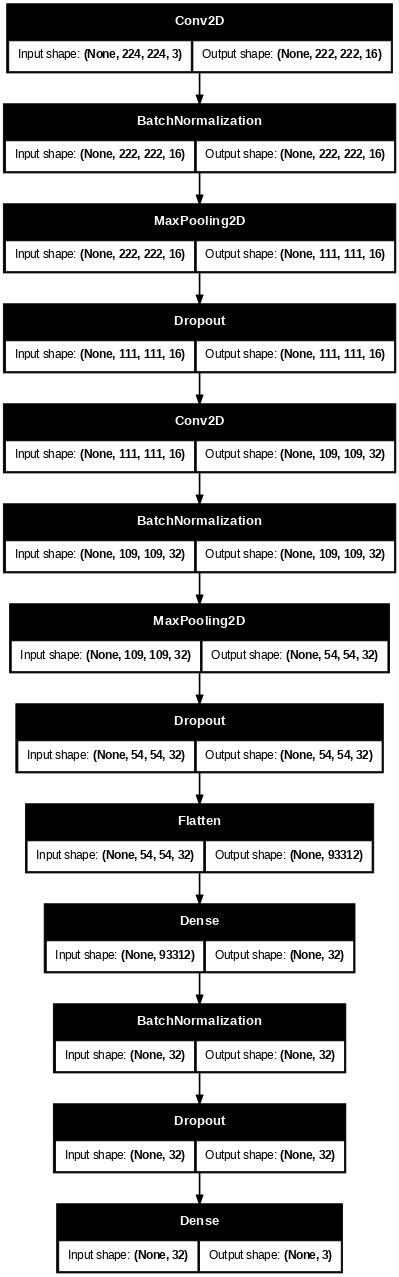

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
keras.utils.plot_model(model_CNN,show_shapes=True,dpi=60)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
## We add the early_stopping according to the loss
## reason:it provides a more sensitive and immediate indication of model overfitting compared to val_accuracy, ensuring more reliable early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_CNN = model_CNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight,
    callbacks=[early_stopping]
)

Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.4245 - loss: 1.4304 - val_accuracy: 0.0415 - val_loss: 17.0173
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.5370 - loss: 0.9826 - val_accuracy: 0.0415 - val_loss: 45.7144
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.5609 - loss: 0.9159 - val_accuracy: 0.2444 - val_loss: 9.0420
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 46s 233ms/step - accuracy: 0.6185 - loss: 0.7925 - val_accuracy: 0.4282 - val_loss: 2.9933
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 0.6627 - loss: 0.7191 - val_accuracy: 0.4440 - val_loss: 2.0881
Epoch 6/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - accuracy: 0.6799 - loss: 0.6901 - val_accuracy: 0.6054 - val_loss: 0.9062
Epoch 7/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.6933 - loss: 0.6501 - val_accuracy: 0.6876 - val_loss: 0.7552
Epoch 8/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 221ms/step - accuracy: 0.7198 - loss:

In [ ]:
loss_CNN = history_CNN.history['loss']
val_loss_CNN = history_CNN.history['val_loss']
accuracy_CNN = history_CNN.history['accuracy']
val_accuracy_CNN = history_CNN.history['val_accuracy']
epochs = range(1, len(accuracy_CNN) + 1)

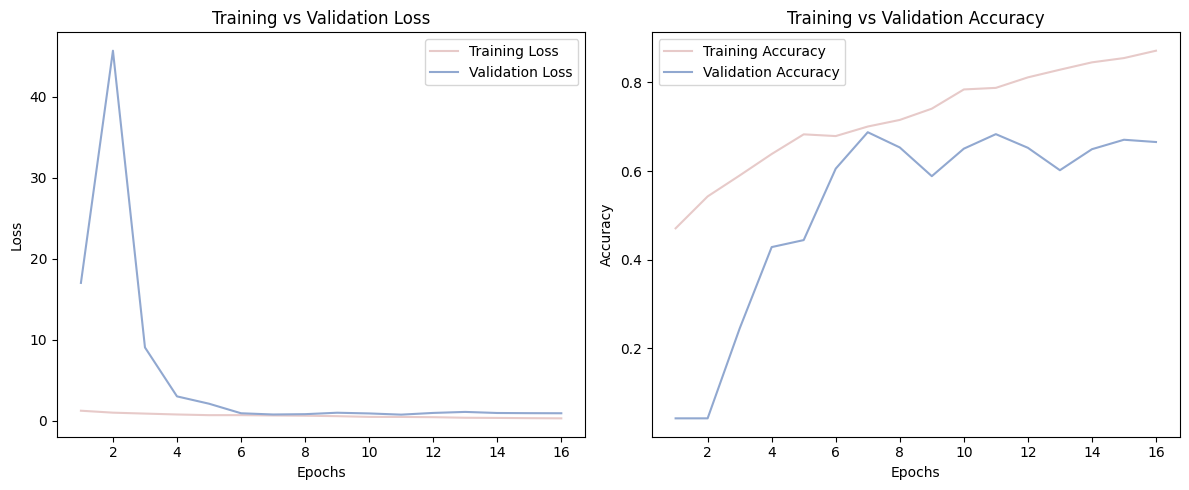

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(epochs, loss_CNN, c='#E7CAC9', label='Training Loss')
axs[0].plot(epochs, val_loss_CNN, c='#91A8D0', label='Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training vs Validation Loss")
axs[0].legend()

axs[1].plot(epochs, accuracy_CNN, c='#E7CAC9', label='Training Accuracy')
axs[1].plot(epochs, val_accuracy_CNN, c='#91A8D0', label='Validation Accuracy')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training vs Validation Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

According to the loss graph and accuracy graph, the result is clear enough.According to the accuracy graph, the training accuracy is really high accordingly, but the problem is that the validation accuracy is far lower than the training accuracy, with around 0.66 compared to the training accuracy, which is around 0.87. This means that this model has the overfitting problem. However, in the model, we have added drop_out layer as well as regulaizer in the second layer to try to solve the overfitting problem. It seems like the accuracy for the model are good. But the overfitting problem still need to be solved. This is also reflected from the loss graph, the training loss is always dropping gradually, but the validation loss drops dramatically at the beginning but after the 8 round it starts to have variation, meaning the problem of overfitting.

## **CNN + Attention Model**

In [ ]:
# This section contains the suggestions with ChatGPT
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (224, 224, 3)
num_classes = 3

inputs = layers.Input(shape=input_shape)

## First put the convolution layers here, because we always meet the problem of overfitting, we add regularizer at the beginning.
## Also with the batchNormalization

### First, put the simple filters to find the easiest part of the images, but make the output still the same size for the next layers
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

### This part, we add the filters to 64, which let the model find more details in the images.
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

### This part is the third part and we add the filters to 128 to find most details contained in the images.
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)

### Attention: fire is not regularly shaped in all the images, so we need the model to have catch the importance features in the images
h, w, c = x.shape[1], x.shape[2], x.shape[3]
x_reshaped = layers.Reshape((h * w, c))(x) # change the 3d vectors to a sequential vectors
x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x_reshaped, x_reshaped) # understand the images in 4 heads.
x = layers.Reshape((h, w, c))(x)

# Residual: keep important information while learning new things
residual = x
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])

# Final layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_attn = models.Model(inputs=inputs, outputs=outputs)

model_attn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_attn.summary()
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3136, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3136, 128) │     66,048 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]   

 Total params: 527,907 (2.01 MB)

 Trainable params: 526,755 (2.01 MB)

 Non-trainable params: 1,152 (4.50 KB)

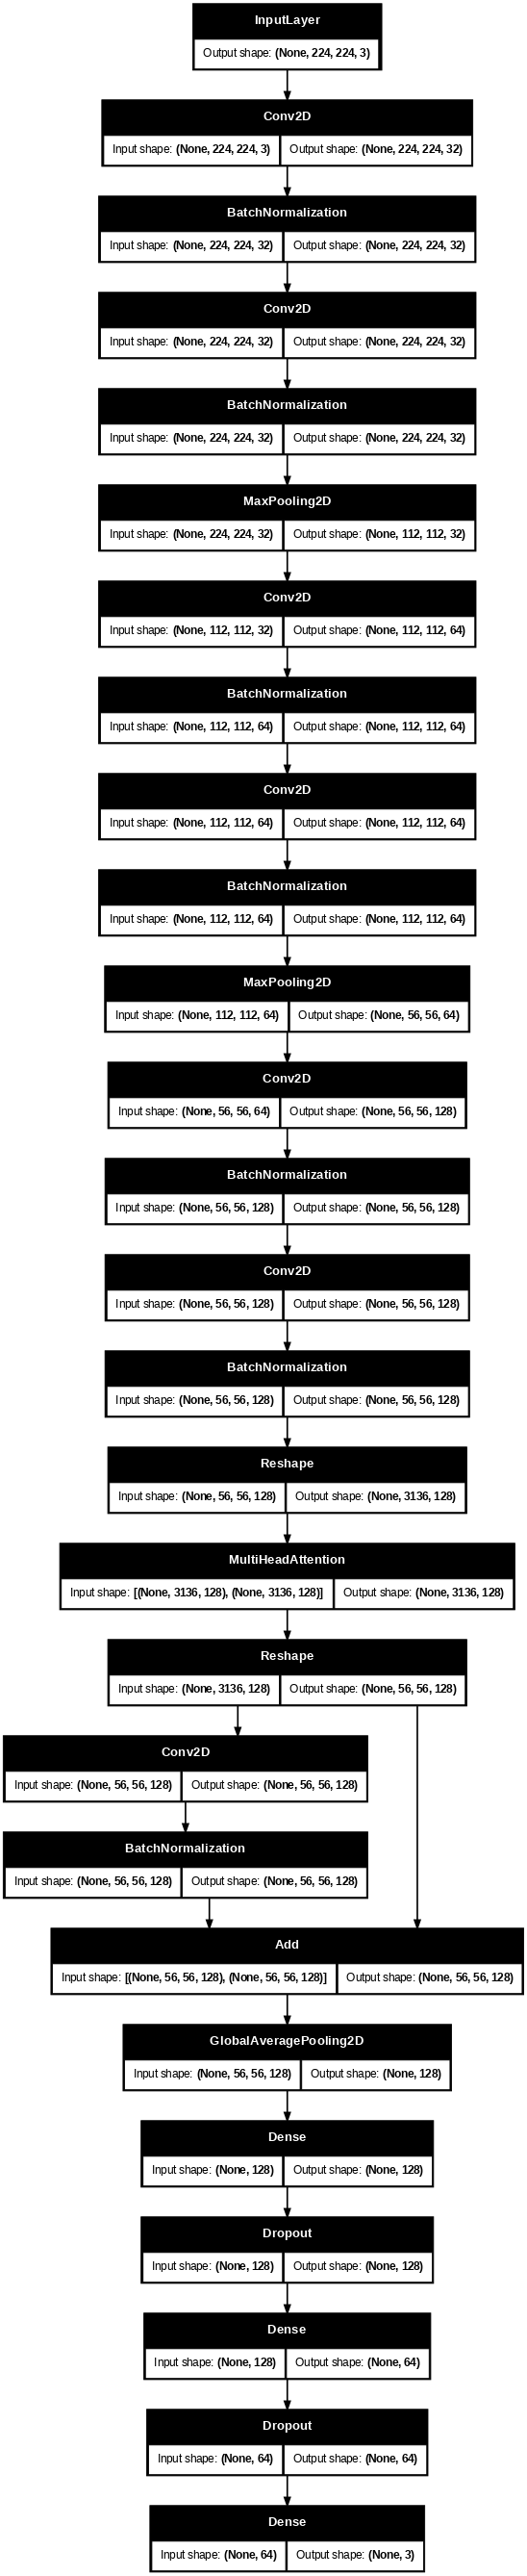

In [ ]:
keras.utils.plot_model(model_attn,show_shapes=True,dpi=60)

In [ ]:
history_attn = model_attn.fit(train_ds, validation_data=val_ds, epochs=50,callbacks=early_stop, class_weight =class_weight)

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.4637 - loss: 1.3733 - val_accuracy: 0.0415 - val_loss: 1.5683
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.5196 - loss: 1.1025 - val_accuracy: 0.0415 - val_loss: 2.9635
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 488s 3s/step - accuracy: 0.5647 - loss: 0.9566 - val_accuracy: 0.5152 - val_loss: 1.0500
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.6042 - loss: 0.8667 - val_accuracy: 0.5631 - val_loss: 0.9564
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.6379 - loss: 0.8113 - val_accuracy: 0.5666 - val_loss: 0.9289
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.6340 - loss: 0.7918 - val_accuracy: 0.6785 - val_loss: 0.7567
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.6179 - loss: 0.8004 - val_accuracy: 0.5698 - val_loss: 0.9558
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 468s 3s/step - accuracy: 0.6398 - loss: 0.7327 - val_accu

In [ ]:
loss_attn = history_attn.history['loss']
val_loss_attn = history_attn.history['val_loss']
accuracy_attn = history_attn.history['accuracy']
val_accuracy_attn = history_attn.history['val_accuracy']
epochs = range(1, len(accuracy_attn) + 1)

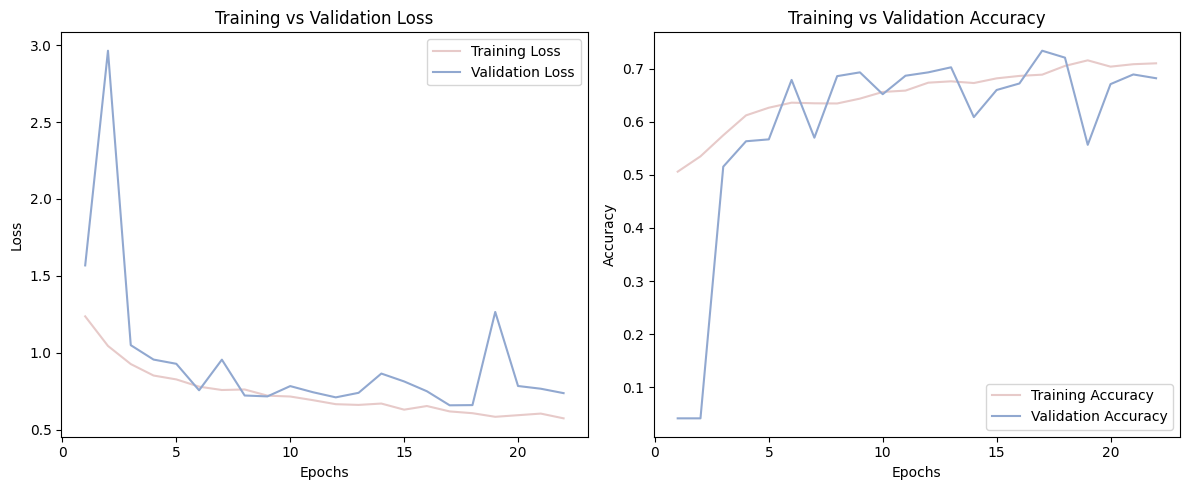

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(epochs, loss_attn, c='#E7CAC9', label='Training Loss')
axs[0].plot(epochs, val_loss_attn, c='#91A8D0', label='Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training vs Validation Loss")
axs[0].legend()

axs[1].plot(epochs, accuracy_attn, c='#E7CAC9', label='Training Accuracy')
axs[1].plot(epochs, val_accuracy_attn, c='#91A8D0', label='Validation Accuracy')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training vs Validation Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In this part, an enhanced CNN architecture incorporating attention mechanisms was developed for fire image classification across three classes. The model was carefully designed with progressive convolutional blocks, batch normalization, L2 regularization, and a multi-head attention layer to capture both local and global features. A residual connection was also added to preserve essential information during learning. The model was trained with an early stopping mechanism to prevent overfitting. Throughout 22 epochs, the model achieved a training accuracy of approximately 70.6% and a validation accuracy peaking at 73.35%, with a corresponding validation loss of 0.6592 at the best epoch (epoch 17). The training and validation curves show good convergence overall, with some fluctuations in validation performance, suggesting mild data variance or sensitivity to harder examples.

## **CNN + Attention with Transformer Model**

In [ ]:
# This section contains the suggestions with ChatGPT
# The transformer: Norm → Work → Add
def transformer_block(inputs, num_heads=4, key_dim=64, ff_dim=128, dropout=0.1):
  # self_attention:
    x = layers.LayerNormalization(epsilon=1e-6)(inputs) # normalization
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x) # attention
    attn_output = layers.Dropout(dropout)(attn_output)
    x = layers.Add()([inputs, attn_output]) # add the original inputs
  # Feed-Forward Network (from ChatGPT)
    x_norm = layers.LayerNormalization(epsilon=1e-6)(x) # normalization
    ffn = layers.Dense(ff_dim, activation='relu')(x_norm) # the dense layer with Feed-Forward Network
    # Independently enhance the complexity and expressive power of each position's features.
    # It complements the cross-position communication handled by the Attention mechanism, enabling the model to become more intelligent and refined
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    return layers.Add()([x, ffn])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (224, 224, 3)
num_classes = 3
l2_weight = 1e-4
dropout_rate = 0.3

inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(x)
x = layers.BatchNormalization()(x)

h, w, c = x.shape[1], x.shape[2], x.shape[3]
x = layers.Reshape((h * w, c))(x)

# Transformer
x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=128, dropout=dropout_rate)

x = layers.Reshape((h, w, c))(x)

residual = x
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])

# Final layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# ------------------- COMPILE -------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3136, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 3136, 128) │        256 │ reshape[0][0]     │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 627,428 (2.39 MB)

 Trainable params: 626,276 (2.39 MB)

 Non-trainable params: 1,152 (4.50 KB)

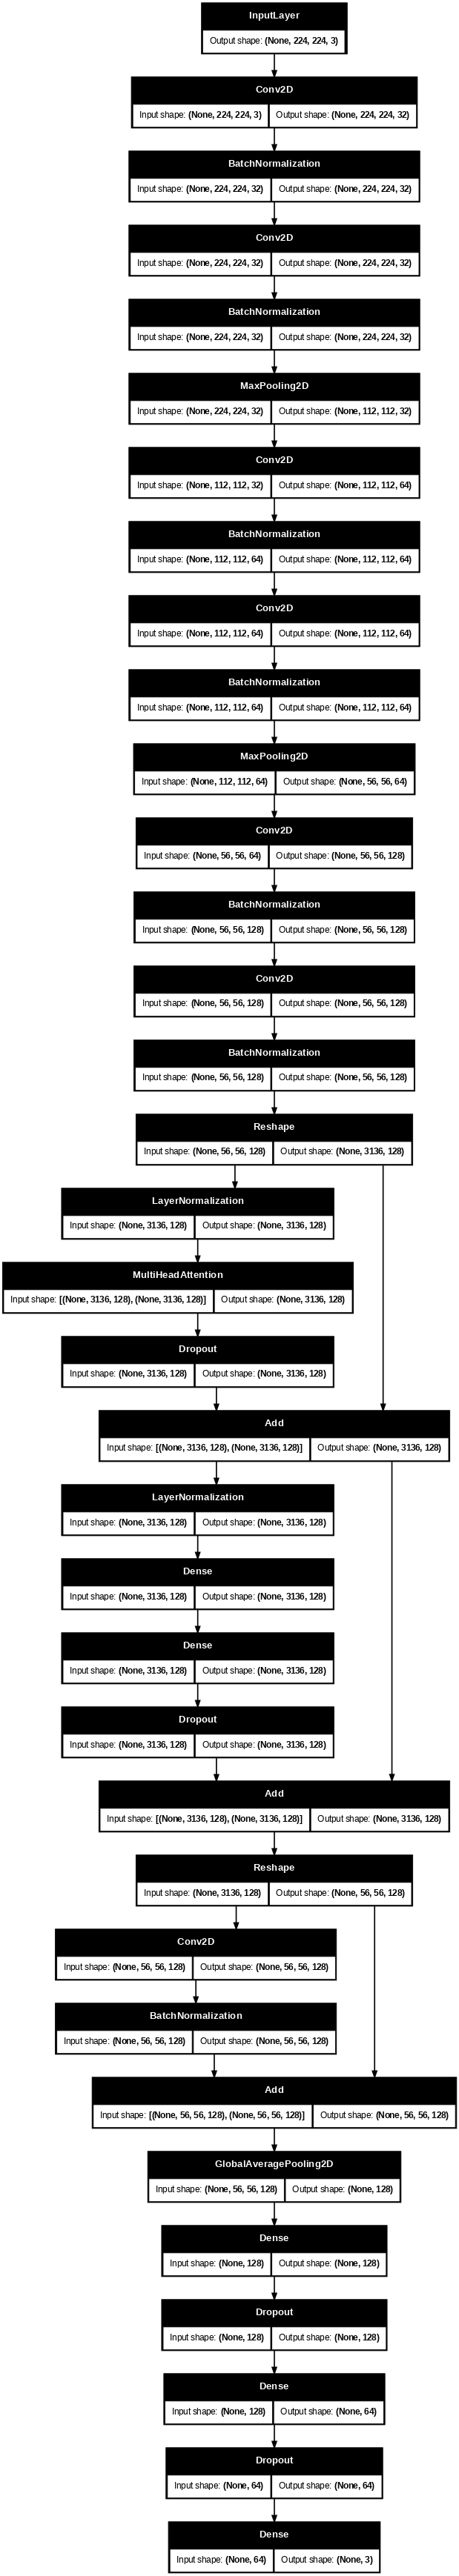

In [ ]:
keras.utils.plot_model(model,show_shapes=True,dpi=60)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
# add a learning rate changing function (from ChatGPT) to improve the model performance and learning speed
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight =class_weight
)


Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 763s 4s/step - accuracy: 0.5071 - loss: 1.2508 - val_accuracy: 0.0431 - val_loss: 1.3929 - learning_rate: 1.0000e-04
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - accuracy: 0.5117 - loss: 1.1445 - val_accuracy: 0.1471 - val_loss: 1.6271 - learning_rate: 1.0000e-04
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5453 - loss: 1.0184
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
185/185 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.5454 - loss: 1.0182 - val_accuracy: 0.3155 - val_loss: 1.5427 - learning_rate: 1.0000e-04
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.5822 - loss: 0.9169 - val_accuracy: 0.6354 - val_loss: 0.8738 - learning_rate: 5.0000e-05
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - accuracy: 0.6030 - loss: 0.8940 - val_accuracy: 0.6275 - val_loss: 0.8936 - learning_rate: 5.0000e-05
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

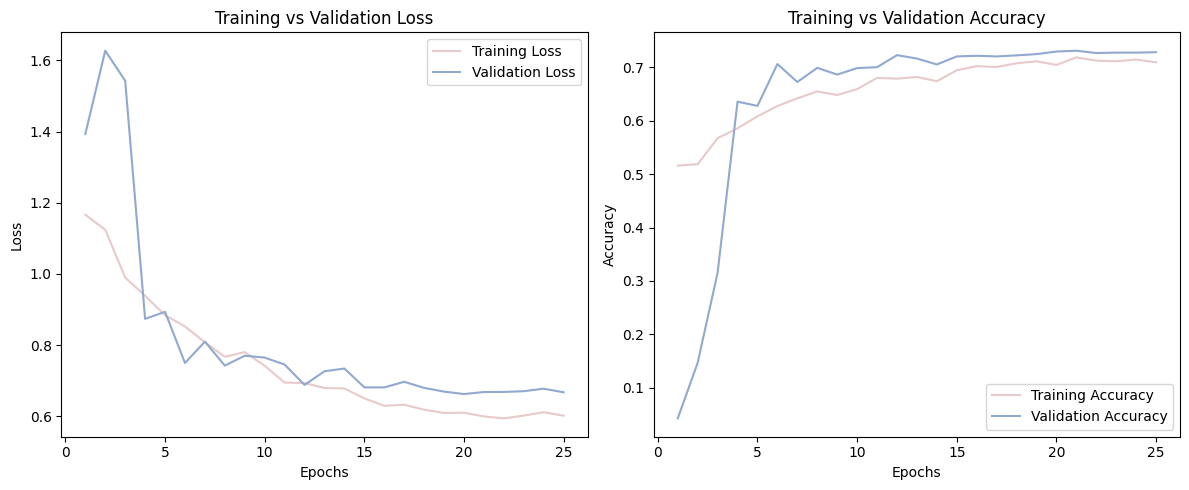

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(epochs, loss, c='#E7CAC9', label='Training Loss')
axs[0].plot(epochs, val_loss, c='#91A8D0', label='Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training vs Validation Loss")
axs[0].legend()

axs[1].plot(epochs, accuracy, c='#E7CAC9', label='Training Accuracy')
axs[1].plot(epochs, val_accuracy, c='#91A8D0', label='Validation Accuracy')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training vs Validation Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In this work, an enhanced CNN architecture incorporating both attention mechanisms and a Transformer block was developed for fire image classification across three classes. The model was carefully designed with progressive convolutional blocks, batch normalization, L2 regularization, and a multi-head self-attention layer to capture both local and global feature representations. A Transformer block was integrated after the convolutional layers to further strengthen long-range feature relationships. In addition, a residual connection was introduced to preserve essential information during feature learning. The model was trained with a combination of ReduceLROnPlateau and early stopping strategies to optimize performance and prevent overfitting. Over 25 epochs, the model achieved a final training accuracy of approximately 71% and a validation accuracy peaking at 73.5%, with the validation loss gradually decreasing to around 0.66. The training and validation curves show good convergence overall, with minor fluctuations in validation performance suggesting some data variability or sensitivity to challenging examples.

## **Pre-trained Model**

### ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load pre-trained ResNet50
base_model = ResNet50(
    weights='imagenet',       # Load weights pre-trained on ImageNet
    include_top=False,        # Exclude the original fully connected layer at the top
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the base

# Build the model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),     # Preprocess input images according to ResNet50 standards
    base_model,                          # Pre-trained ResNet50 base model
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,243 (92.02 MB)

 Trainable params: 529,923 (2.02 MB)

 Non-trainable params: 23,592,320 (90.00 MB)

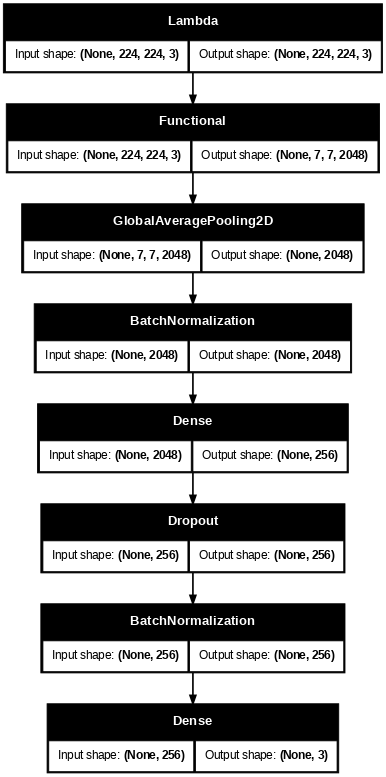

In [ ]:
keras.utils.plot_model(model,show_shapes=True,dpi=60)

In [ ]:
# Training Model
history = model.fit(train_ds,validation_data=val_ds,epochs=20,class_weight=class_weight)

Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.3504 - loss: 1.4202 - val_accuracy: 0.5603 - val_loss: 0.8632
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.4203 - loss: 1.1759 - val_accuracy: 0.5947 - val_loss: 0.9081
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.4800 - loss: 1.0491 - val_accuracy: 0.5639 - val_loss: 0.9375
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.5011 - loss: 1.0239 - val_accuracy: 0.5840 - val_loss: 0.8967
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.5412 - loss: 0.9309 - val_accuracy: 0.6236 - val_loss: 0.8575
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.5569 - loss: 0.9015 - val_accuracy: 0.6220 - val_loss: 0.8432
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.5463 - loss: 0.8420 - val_accuracy: 0.6354 - val_loss: 0.8528
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.5737 - loss: 0.8196 - val_accu

In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

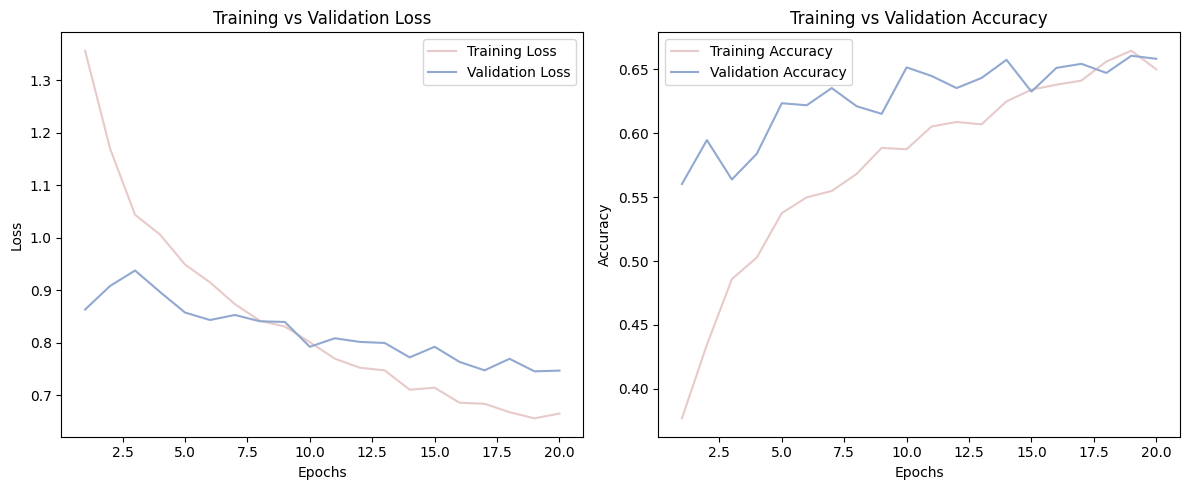

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(epochs, loss, c='#E7CAC9', label='Training Loss')
axs[0].plot(epochs, val_loss, c='#91A8D0', label='Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training vs Validation Loss")
axs[0].legend()

axs[1].plot(epochs, accuracy, c='#E7CAC9', label='Training Accuracy')
axs[1].plot(epochs, val_accuracy, c='#91A8D0', label='Validation Accuracy')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training vs Validation Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

We built an image classification pre-trained model -- ResNet50 model as the feature extractor. The base ResNet50 model was frozen to leverage its pre-learned features from ImageNet. Across 20 epochs of training, the model demonstrated steady improvements in both training and validation performance. The training accuracy increased from 35% to approximately 65%, while validation accuracy improved from 56% to around 66%. Training loss consistently decreased, and validation loss showed a general downward trend despite some minor fluctuations, suggesting that the model was learning effectively without severe overfitting. The final model achieved a validation accuracy of 65.8%.

### MobileNetV2

#### Data Preprocessing

In [ ]:
## the data augmentation should be separate with the process_image becuase only training data will be applied for data augmentation.
def augment_1(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    img = tf.image.random_hue(img, 0.08)
    img = tf.image.random_crop(img, size=[200, 200, 3])
    img = tf.image.resize(img, [224, 224])
    return img, label

In [ ]:
# create datasets
# As we have about 8000 images, it is better for us to have the automatic optimized parallel processing numbers.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment_1, num_parallel_calls=tf.data.AUTOTUNE)  # augment only in train_ds
train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

#### Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
IMG_SIZE = (224, 224) # image size
NUM_CLASSES = 3       # Number of target classes: large, middle, small

# Load pre-trained MobileNetV2 (excluding top classification layer)
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base

# Build model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = preprocess_input(inputs)
x = base_model(x, training= False) # Forward pass through the base model
x = layers.GlobalAveragePooling2D()(x) # Global average pooling to reduce dimensions
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax',
                       kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # L2 regularization to prevent overfitting

model = models.Model(inputs, outputs)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

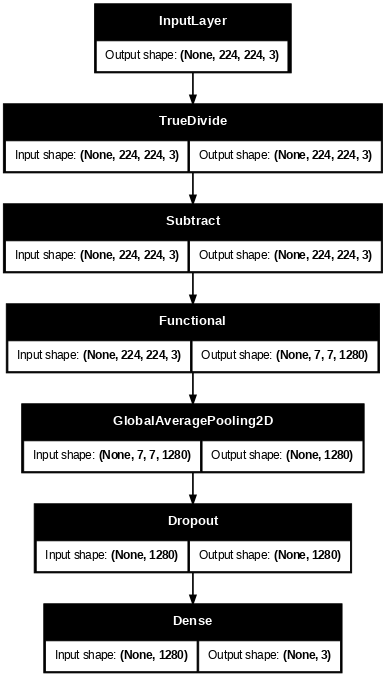

In [ ]:
keras.utils.plot_model(model,show_shapes=True,dpi=60)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Stop training when validation loss does not improve for 5 consecutive epochs
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]


In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, class_weight=class_weight, callbacks=callbacks)

Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 130s 611ms/step - accuracy: 0.3216 - loss: 2.0796 - val_accuracy: 0.3982 - val_loss: 1.4604
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 103s 515ms/step - accuracy: 0.3090 - loss: 1.7031 - val_accuracy: 0.3982 - val_loss: 1.2397
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 97s 508ms/step - accuracy: 0.3181 - loss: 1.5646 - val_accuracy: 0.4223 - val_loss: 1.1413
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 103s 514ms/step - accuracy: 0.3461 - loss: 1.4880 - val_accuracy: 0.5603 - val_loss: 1.1111
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 104s 522ms/step - accuracy: 0.3458 - loss: 1.4193 - val_accuracy: 0.5603 - val_loss: 1.1075
Epoch 6/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 101s 510ms/step - accuracy: 0.3680 - loss: 1.4600 - val_accuracy: 0.5603 - val_loss: 1.1147
Epoch 7/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 102s 511ms/step - accuracy: 0.3809 - loss: 1.4054 - val_accuracy: 0.5603 - val_loss: 1.1164
Epoch 8/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 101s 506ms/step - accuracy: 0.3774 - 

In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

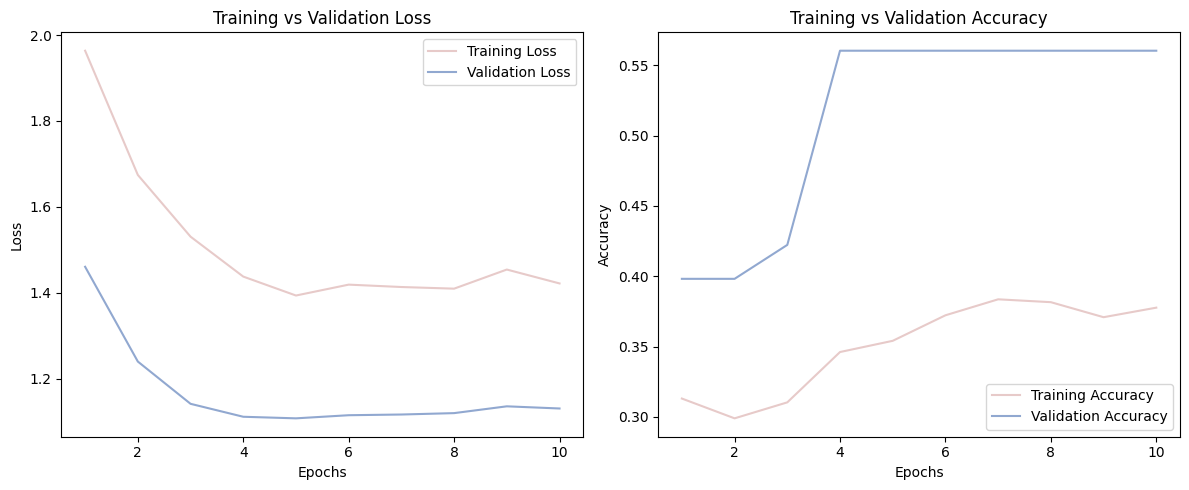

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(epochs, loss, c='#E7CAC9', label='Training Loss')
axs[0].plot(epochs, val_loss, c='#91A8D0', label='Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training vs Validation Loss")
axs[0].legend()

axs[1].plot(epochs, accuracy, c='#E7CAC9', label='Training Accuracy')
axs[1].plot(epochs, val_accuracy, c='#91A8D0', label='Validation Accuracy')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training vs Validation Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

We built an image classification pre-trained model -- MobileNetV2 with frozen weights as a feature extractor. A custom classification head was added and trained on the fire dataset categorized into three classes. Over 10 epochs, the training loss steadily decreased, and validation loss initially dropped before stabilizing, as shown in the left plot. The model achieved a validation accuracy of approximately 56%, while the training accuracy remained lower, around 37%, suggesting underfitting. Early stopping was triggered after epoch 10, as no further improvement in validation loss was observed. The validation accuracy plateaued early, indicating that the frozen base model may limit learning capacity.

## **SHAP**

As the CNN + attention with transformer model is the best model that we have after all the trails. The SHAP and LIME are done based on this model.

In [ ]:
!pip install shap opencv-python

In [ ]:
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2

2025-04-28 16:29:18.485993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 16:29:18.497741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 16:29:18.511758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 16:29:18.515938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 16:29:18.526235: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
model = tf.keras.models.load_model('final_fire_model.keras')

In [ ]:
df = pd.read_csv("gs://dataproc-staging-us-central1-598287031254-svjohk1w/labels_with_paths.csv")
bucket_path = "gs://dataproc-staging-us-central1-598287031254-svjohk1w/images"
df['filepath'] = df['filename'].apply(lambda x: f"{bucket_path}/{x}")

In [ ]:
def load_image_gcs(filepath):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    return img
indices = [0, 5, 10]

In [ ]:
selected_images = []
for idx in indices:
    image_path = df['filepath'].iloc[idx]
    img = load_image_gcs(image_path).numpy()  # Load image and convert to numpy
    selected_images.append(img)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [00:55<00:00, 14.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [01:11, 23.88s/it]                       


IndexError: index 1 is out of bounds for axis 1 with size 1

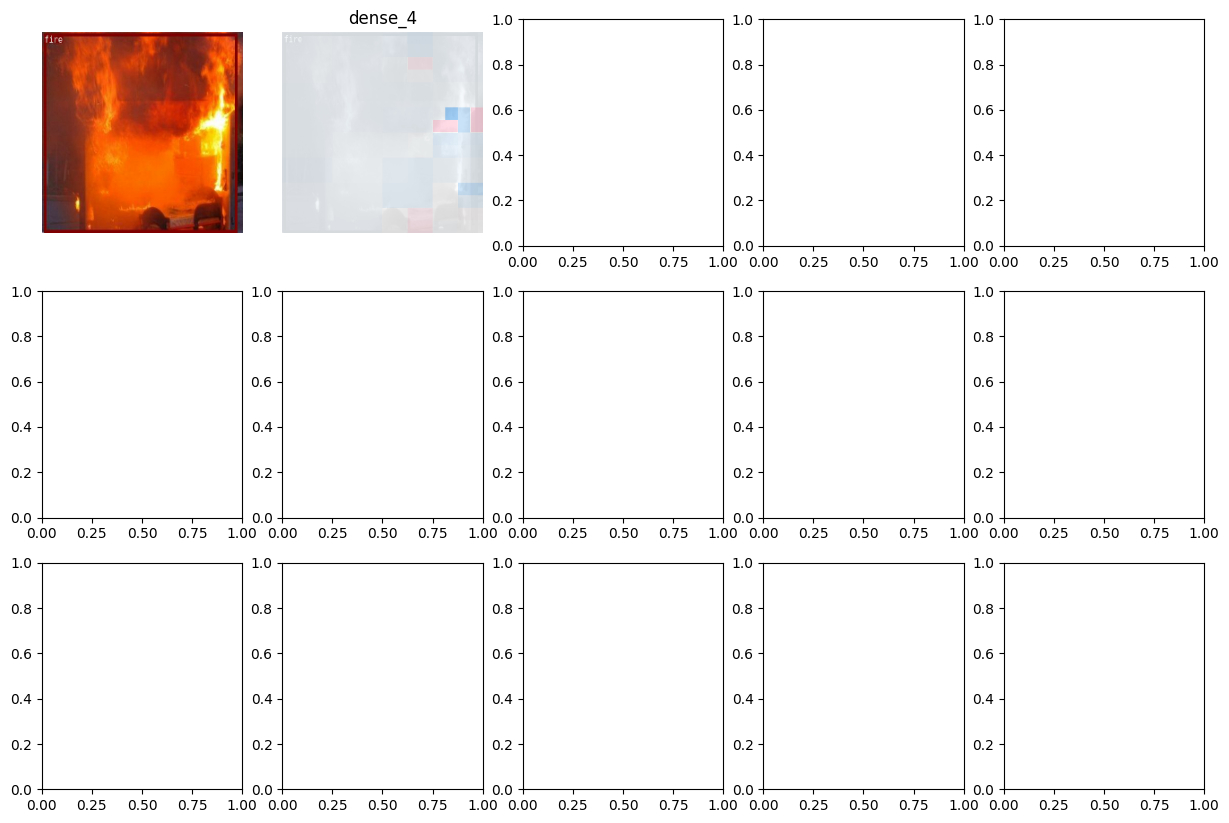

In [ ]:
selected_images_batch = np.stack(selected_images, axis=0)

explainer = shap.Explainer(
    model,
    shap.maskers.Image("inpaint_telea", (224, 224, 3))
)

shap_values = explainer(selected_images_batch)

shap.image_plot(shap_values)

## **LIME**

In [ ]:
!pip install lime


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 82.4 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283884 sha256=7d4534df4156b72e021c4c5c0215f5dfd5b3b14b6a9e6b9b30788e94a51f39e3
  Stored in directory: /home/jupyter/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from lime import lime_image
from skimage.segmentation import mark_boundaries


In [ ]:
def load_image_gcs(gcs_path):
    img = tf.io.read_file(gcs_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0  # Normalize
    return img


In [ ]:
# Image from our dataset
image_path = df['filepath'].iloc[0]

img = load_image_gcs(image_path).numpy()

img_batch = np.expand_dims(img, axis=0)


In [ ]:
# ----------- LIME EXPLAINER FOR MULTIPLE IMAGES -----------

def explain_multiple_images(df, indices, model, num_features=5, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()

    fig, axs = plt.subplots(1, len(indices), figsize=(5 * len(indices), 5))

    if len(indices) == 1:
        axs = [axs]

    for idx, ax in zip(indices, axs):
        image_path = df['filepath'].iloc[idx]
        img = load_image_gcs(image_path).numpy()

        # Prediction function for LIME
        def predict_fn(images):
            images = tf.convert_to_tensor(images)
            preds = model.predict(images)
            return preds

        # Run LIME
        explanation = explainer.explain_instance(
            img,
            predict_fn,
            top_labels=3,
            hide_color=0,
            num_samples=num_samples
        )

        temp, mask = explanation.get_image_and_mask(
            label=explanation.top_labels[0],
            positive_only=True,
            hide_rest=False,
            num_features=num_features,
            min_weight=0.0
        )

        # Plot
        ax.imshow(mark_boundaries(temp, mask))
        ax.axis('off')
        ax.set_title(f"Image {idx}")

    plt.tight_layout()
    plt.suptitle('LIME Explanations on Multiple Fire Images', fontsize=20)
    plt.subplots_adjust(top=0.85)
    plt.show()

    fig.savefig('lime_explanations_grid.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

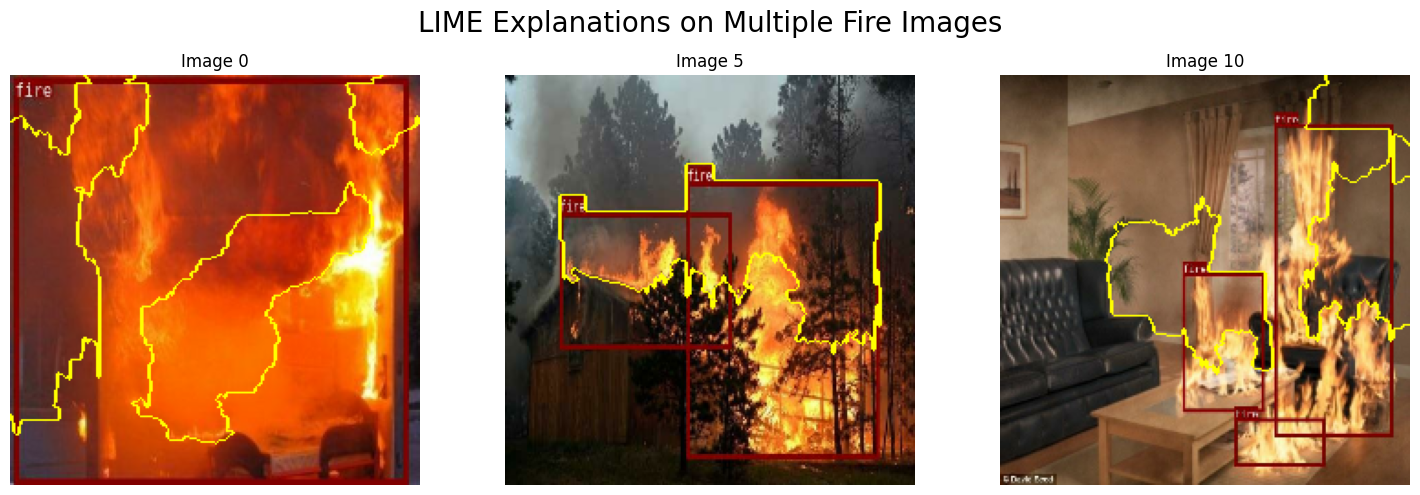

In [ ]:
explain_multiple_images(df, indices=[0, 5, 10], model=model)


In [ ]:
df.iloc[[0, 5, 10]][['filename', 'label']]

filename  label
0    large_(1).jpg  large
5    large_(6).jpg  large
10  large_(11).jpg  large

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

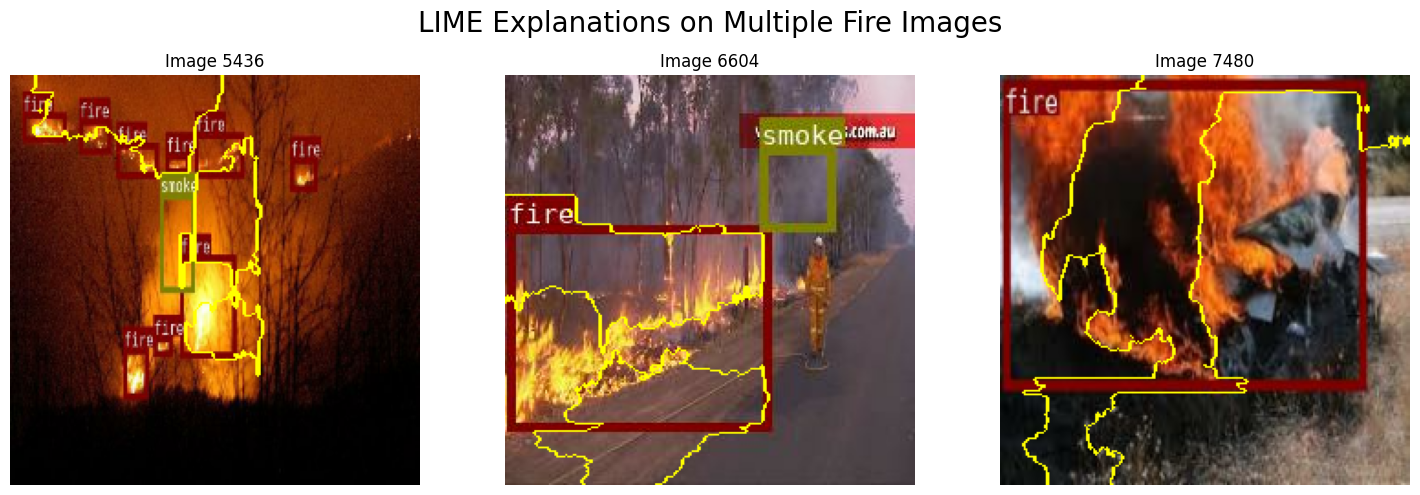

In [ ]:
explain_multiple_images(df, indices=[5436, 6604, 7480], model=model)


In [ ]:
df.iloc[[5436, 6604, 7480]][['filename', 'label']]


filename   label
5436  middle_(2080).jpg  middle
6604  middle_(3248).jpg  middle
7480  middle_(4124).jpg  middle

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

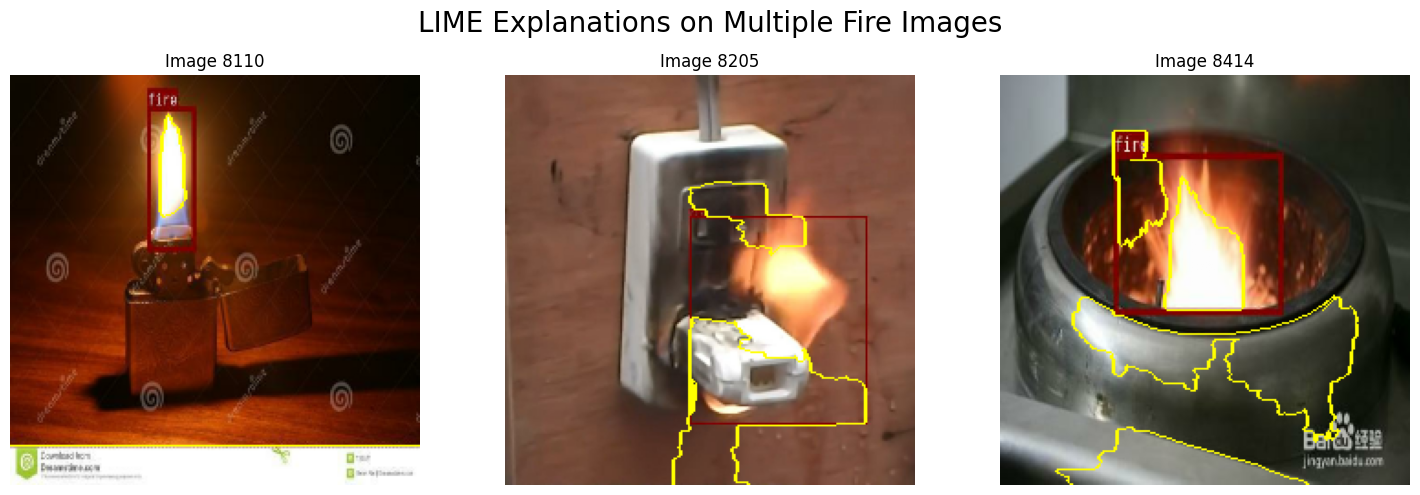

In [ ]:
explain_multiple_images(df, indices=[8110, 8205, 8414], model=model)


In [ ]:
df.iloc[[8110, 8205, 8414]][['filename', 'label']]


filename  label
8110   small_(32).jpg  small
8205  small_(127).jpg  small
8414  small_(336).jpg  small

In [ ]:
def explain_and_plot_side_by_side(df, idx, model, num_features=5, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()

    image_path = df['filepath'].iloc[idx]
    img = load_image_gcs(image_path).numpy()

    # Prediction function
    def predict_fn(images):
        images = tf.convert_to_tensor(images)
        preds = model.predict(images)
        return preds

    # Run LIME
    explanation = explainer.explain_instance(
        img,
        predict_fn,
        top_labels=3,
        hide_color=0,
        num_samples=num_samples
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=num_features,
        min_weight=0.0
    )

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title('Original Fire Image')

    # LIME highlighted image
    axs[1].imshow(mark_boundaries(temp, mask))
    axs[1].axis('off')
    axs[1].set_title('LIME Explained Prediction')

    plt.tight_layout()
    plt.show()

    fig.savefig(f'lime_before_after_{idx}.png')


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

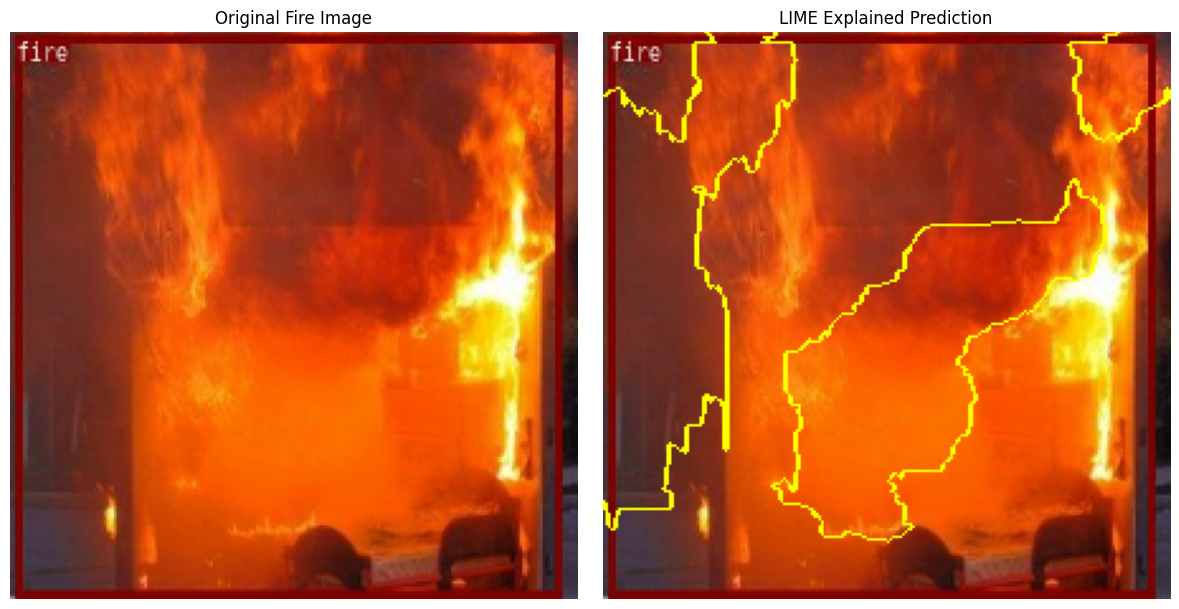

In [ ]:
explain_and_plot_side_by_side(df, idx=0, model=model)


## Suggestion for Improvement

**Data Augmentation Enhancements**

We plan to implement more targeted augmentation strategies such as zooming in and out, which may help the model learn spatial features more effectively, especially for smaller fires.

**Confusion Matrix Analysis**

Adding a confusion matrix would allow us to better understand where the model is getting confused, and we aim to focus more on improving recall, particularly for underrepresented classes like small fires.

**More Data for Small Fires**

Small fire images are significantly underrepresented in our dataset. Acquiring more samples for this class would help balance the data and improve the model’s sensitivity to early-stage fires.

**Include a “No Fire” Class**

Introducing a fourth class for images without fire would make the model more applicable in real-world use, helping to avoid false positives.

**Upgrade Infrastructure**

With more funding and access to stronger GPUs, we could train more advanced models more efficiently and experiment with newer architectures or larger datasets.
